This notebook is to explore, visualize, and analyze the Ames Housing Dataset for the Kaggle getting started competition ["House Prices - Advanced Regression Techniques."](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview). It includes data for residential home sales in Ames, Iowa. The goal of this competition is to predict the home price.

First thing, of course, we need to import the training data. Then we can start looking at it to learn more about it.

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv', index_col='Id')

display(df.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

It looks like some columns have missing values. There are 1,460 records in this data set and 80 columns.

I noticed when looking at the [codebook](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=data_description.txt) that "MSZoning" could possibly include non-residential classifications. 

> MSZoning: Identifies the general zoning classification of the sale.

>       A    Agriculture
>       C    Commercial
>       FV    Floating Village Residential
>       I    Industrial
>       RH    Residential High Density
>       RL    Residential Low Density
>       RP    Residential Low Density Park 
>       RM    Residential Medium Density


I wonder how many of them are in this dataset?

In [16]:
display(df['MSZoning'].value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

The vast majority of the data is zoned for residential, low density housing. There are some others and even some commercial properties.

Since our target variable is the "SalePrice", I want to get some information about it.

In [17]:
display(df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

There is some distance between the mean and median, indicating skew to the right pulling the mean higher.

Somehow I've always been under the impression that there is a seasonality to house prices. They are most expensive in the summer and least expensive in the winter. Let's take a look at the influence that has on the price.

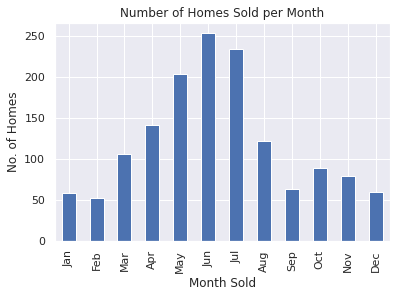

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

months = df['MoSold'].value_counts().sort_index()
bars = months.plot(kind='bar')
bars.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month Sold')
plt.ylabel('No. of Homes')
plt.title('Number of Homes Sold per Month')
plt.show()

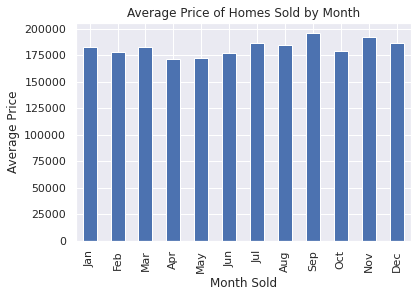

In [19]:
price_by_neighborhood = df.groupby('MoSold').mean()['SalePrice']
bars = price_by_neighborhood.plot(kind='bar')
bars.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Average Price')
plt.xlabel('Month Sold')
plt.title('Average Price of Homes Sold by Month')
plt.show()

Fascinating! My assumption doesn't appear to play out in the data. It looks like, while most homes are sold in May, June, and July, that doesn't have an effect on the prices.

I noticed there isn't a column for total square feet, so I'm going to put one together.

In [20]:
df['TotalLivAreaSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalLivAreaSF'] + df['TotalBsmtSF'] + df['GarageArea']
display(df['TotalSF'].describe())

count     1460.000000
mean      3040.028767
std        958.651371
min        334.000000
25%       2388.000000
50%       2934.000000
75%       3570.750000
max      13170.000000
Name: TotalSF, dtype: float64

The 75th percentile of home size is 3570 square feet, but the max is 13,170? That's a huge house! Let's dig into this a little more. Is this an outlier? Are there a few huge houses?

In [21]:
print(f"95th percentile: {df['TotalSF'].quantile(0.95)}")
print(f"99th percentile: {df['TotalSF'].quantile(0.99)}")

95th percentile: 4712.9
99th percentile: 5600.660000000002


Hm ... even the 99th percentile isn't anywhere near 13,170. Let's look at just the houses in the 99th percentile.

In [22]:
df[df['TotalSF']>5600][['TotalLivAreaSF', 'TotalBsmtSF', 'TotalSF']].sort_values('TotalSF')

,TotalLivAreaSF,TotalBsmtSF,TotalSF
Id,,,
179,2234,2216,5616
333,1629,3206,5715
225,2392,2392,5752
770,3279,1650,5770
305,3493,1470,5833
799,3140,1926,5886
1354,3238,2033,5937
1374,2633,2633,6070
441,2402,3094,6168


It is specifically one house! One house with a rather large basement. I'm concerned that something is wrong with the basement size data. We'll see this more later in visualization. This will be good to remember going forward.

What can we learn about the neighborhoods where these homes are sold?

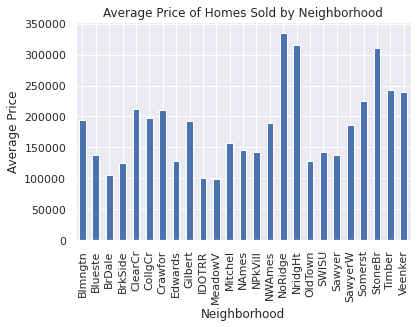

In [23]:
price_by_neighborhood = df.groupby('Neighborhood').mean()['SalePrice']
price_by_neighborhood.plot(kind='bar')
plt.ylabel('Average Price')
plt.title('Average Price of Homes Sold by Neighborhood')
plt.show()

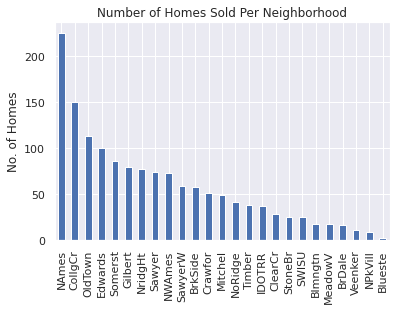

In [24]:
neighborhoods = df['Neighborhood'].value_counts()
neighborhoods.plot(kind='bar')
plt.ylabel('No. of Homes')
plt.title('Number of Homes Sold Per Neighborhood')
plt.show()

The most expensive homes on average were sold in Northridge, Northridge Heights, and Stone Brook, but the most homes were sold in North Ames. 

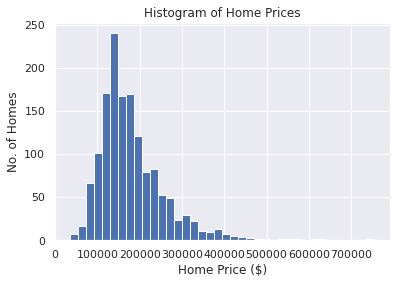

In [25]:
sns.set()

n_bins = int(np.sqrt(df.shape[0]))
plt.hist(df['SalePrice'], bins=n_bins)
plt.xlabel('Home Price ($)')
plt.ylabel('No. of Homes')
plt.title('Histogram of Home Prices')
plt.show()

While most homes fall within the \\$100-200k range, there is an interesting bump around $375,000. As suspected, the distribution is skewed with a longer tail to the right.

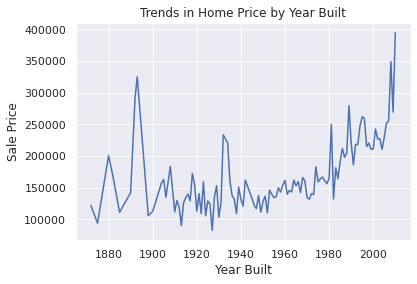

In [26]:
sns.lineplot(x='YearBuilt', y='SalePrice', data=df, ci=None)
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.title('Trends in Home Price by Year Built')
plt.show()

Generally, newer-build homes sell for higher prices. This relationship appears to especially hold after around 1950.

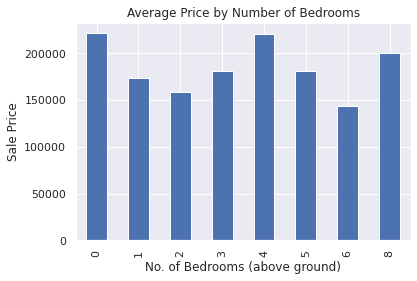

In [27]:
price_by_bedroom = df.groupby('BedroomAbvGr').mean()['SalePrice']
price_by_bedroom.plot(kind='bar')
plt.xlabel('No. of Bedrooms (above ground)')
plt.ylabel('Sale Price')
plt.title('Average Price by Number of Bedrooms')
plt.show()

Not the relationship I expected! This dataset is full of surprises.

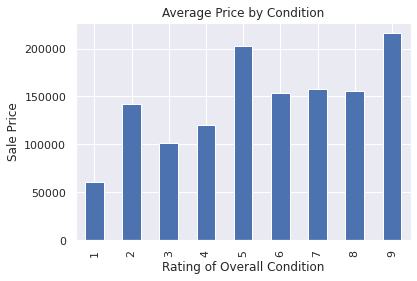

In [28]:
price_by_cond = df.groupby('OverallCond').mean()['SalePrice']
price_by_cond.plot(kind='bar')
plt.xlabel('Rating of Overall Condition')
plt.ylabel('Sale Price')
plt.title('Average Price by Condition')
plt.show()

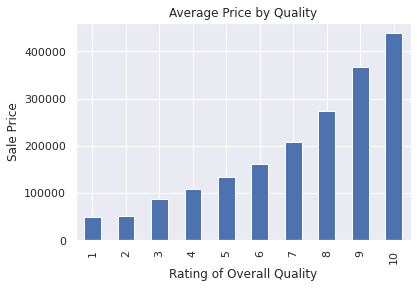

In [29]:
price_by_qual = df.groupby('OverallQual').mean()['SalePrice']
price_by_qual.plot(kind='bar')
plt.xlabel('Rating of Overall Quality')
plt.ylabel('Sale Price')
plt.title('Average Price by Quality')
plt.show()

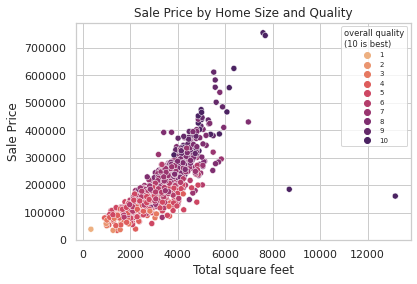

In [30]:
sns.set_style('whitegrid')
sns.scatterplot(x='TotalSF', y='SalePrice', hue='OverallQual', data=df, legend='full', palette='flare')
plt.title('Sale Price by Home Size and Quality')
plt.xlabel('Total square feet')
plt.ylabel('Sale Price')
plt.legend(loc='upper right', title='overall quality\n(10 is best)', fontsize='xx-small', title_fontsize='x-small')
plt.show()

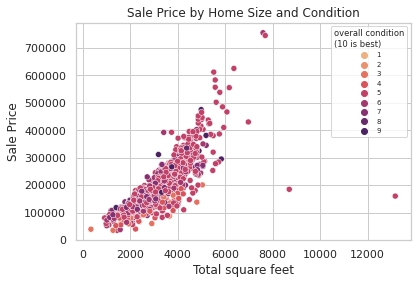

In [31]:
sns.set_style('whitegrid')
sns.scatterplot(x='TotalSF', y='SalePrice', hue='OverallCond', data=df, legend='full', palette='flare')
plt.title('Sale Price by Home Size and Condition')
plt.xlabel('Total square feet')
plt.ylabel('Sale Price')
plt.legend(loc='upper right', title='overall condition\n(10 is best)', fontsize='xx-small', title_fontsize='x-small')
plt.show()

Overall quality and total square footage seem to matter a lot, at least from what we can see with visualization. Overall condition matters as well. Those will be important to think about when we go to model the sale price. There also seems to be an upward trend in year built, but only for homes built after 1950 or so.

We should have a better feel for the data now. Let's start doing some statistics!

In [32]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements.
    
    Args:
      data: an array of values to compute the ECDF for.
      
    Returns:
      Two arrays: x values for the ECDF and y values for the ECDF.
    """
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n

    return x, y

Let's start by seeing whether the sale price is normally distributed. We have already noticed there is a skew to the right. The two graphs below will show evidence that it's not exactly normal.

Percentiles:
2.5: 80000.0
25th: 129975.0
50th: 163000.0
75th: 214000.0
97.5: 384510.7499999999


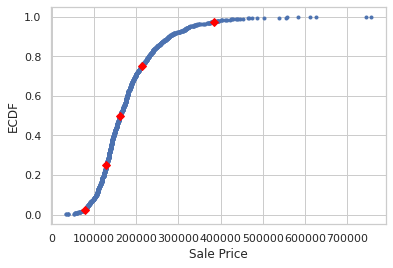

In [33]:
percentiles = np.array([2.5, 25, 50, 75, 97.5])
ptiles = np.percentile(df['SalePrice'], percentiles)
print(f"Percentiles:\n2.5: {ptiles[0]}\n25th: {ptiles[1]}\n50th: {ptiles[2]}\n75th: {ptiles[3]}\n97.5: {ptiles[4]}")

x, y = ecdf(df['SalePrice'])
plt.plot(x, y, marker='.', linestyle='none')
plt.plot(ptiles, percentiles/100, marker='D', color='red', linestyle='none')
plt.xlabel('Sale Price')
plt.ylabel('ECDF')

plt.show()

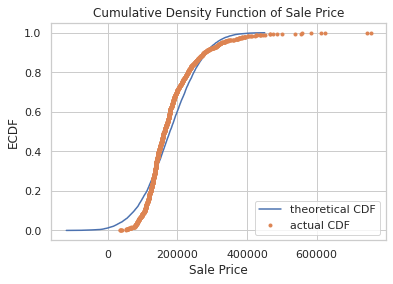

In [34]:
mu = df['SalePrice'].mean()
sigma = df['SalePrice'].std()
samples = np.random.normal(mu, sigma, size=10000)

theoretical_x, theoretical_y = ecdf(samples)
x, y = ecdf(df['SalePrice'])

plt.plot(theoretical_x, theoretical_y, label='theoretical CDF')
plt.plot(x, y, marker='.', linestyle='none', label='actual CDF')
plt.xlabel('Sale Price')
plt.ylabel('ECDF')
plt.title('Cumulative Density Function of Sale Price')
plt.legend(loc='lower right')
plt.show()

We can see more evidence here that the sale price is not exactly normally distributed.

Slope is 67.0875522887501
Intercept is -23026.892983277085


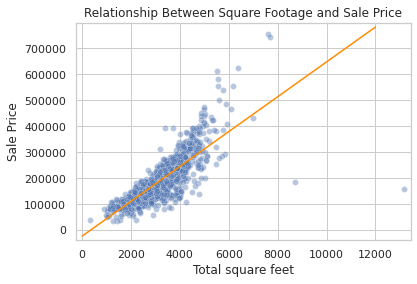

In [35]:
sns.set_style('whitegrid')

sns.scatterplot(x='TotalSF', y='SalePrice', data=df, alpha=0.4)
plt.margins(0.02)
plt.xlabel('Total square feet')
plt.ylabel('Sale Price')
plt.title('Relationship Between Square Footage and Sale Price')

a, b = np.polyfit(df['TotalSF'], df['SalePrice'], 1)
print(f"Slope is {a}")
print(f"Intercept is {b}")

x = np.array([0, 12000])
y = a * x + b

plt.plot(x, y, color='darkorange')

plt.show()

Look all the way to the right. You can see two outliers in the data. How does removing them affect the relationship?

Slope is 74.74389456936635
Intercept is -45481.30686817868


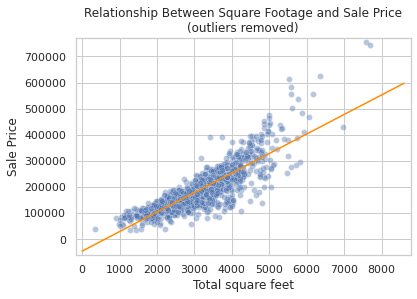

In [36]:
df_outliers_removed = df[df['TotalSF']<8600]

sns.set_style('whitegrid')

sns.scatterplot(x='TotalSF', y='SalePrice', data=df_outliers_removed, alpha=0.4)
plt.margins(0.02)
plt.xlabel('Total square feet')
plt.ylabel('Sale Price')
plt.title('Relationship Between Square Footage and Sale Price\n(outliers removed)')

a, b = np.polyfit(df_outliers_removed['TotalSF'], df_outliers_removed['SalePrice'], 1)
print(f"Slope is {a}")
print(f"Intercept is {b}")

x = np.array([0, 8600])
y = a * x + b

plt.plot(x, y, color='darkorange')

plt.show()

That actually changed the slope and intercept a good deal.

Let's proceed with a subset of the fields that we think have the most effects and see how it goes. We'll start with the full dataset, then try with the outliers removed.

In [37]:
df[['SalePrice', 'TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual']].corr(method='pearson')

,SalePrice,TotalSF,LotArea,BedroomAbvGr,YearBuilt,OverallCond,OverallQual
SalePrice,1.000000,0.809561,0.263843,0.168213,0.522897,-0.077856,0.790982
TotalSF,0.809561,1.000000,0.303583,0.318015,0.404367,-0.157065,0.698060
LotArea,0.263843,0.303583,1.000000,0.119690,0.014228,-0.005636,0.105806
BedroomAbvGr,0.168213,0.318015,0.119690,1.000000,-0.070651,0.012980,0.101676
YearBuilt,0.522897,0.404367,0.014228,-0.070651,1.000000,-0.375983,0.572323
OverallCond,-0.077856,-0.157065,-0.005636,0.012980,-0.375983,1.000000,-0.091932
OverallQual,0.790982,0.698060,0.105806,0.101676,0.572323,-0.091932,1.000000


"TotalSF" and "OverallQual" seem to be having the greatest effects on sale price, but let's throw all of these into a regression to see what happens.

Also, we'll check for multicollinearity.

In [38]:
X_data = df[['TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual']]
display(X_data.corr())

,TotalSF,LotArea,BedroomAbvGr,YearBuilt,OverallCond,OverallQual
TotalSF,1.000000,0.303583,0.318015,0.404367,-0.157065,0.698060
LotArea,0.303583,1.000000,0.119690,0.014228,-0.005636,0.105806
BedroomAbvGr,0.318015,0.119690,1.000000,-0.070651,0.012980,0.101676
YearBuilt,0.404367,0.014228,-0.070651,1.000000,-0.375983,0.572323
OverallCond,-0.157065,-0.005636,0.012980,-0.375983,1.000000,-0.091932
OverallQual,0.698060,0.105806,0.101676,0.572323,-0.091932,1.000000


In [39]:
import statsmodels.api as sm

y = df['SalePrice']
X = X_data
X = sm.add_constant(X)
linear = sm.OLS(endog=y, exog=X)
results = linear.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     830.3
Date:                Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:03:48   Log-Likelihood:                -17458.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1453   BIC:                         3.497e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.498e+05   8.69e+04     -9.776      0.000   -1.02e+06   -6.79e+05
TotalSF         41.0448      1.636     25.095      0.000      37.836      44.253
LotArea          0.6082      0.106      5.755      0.000       0.401       0.815
BedroomAbvGr -2596.1580   1320.770     -1.966      0.050   -5186.977      -5.339
YearBuilt      377.2653     44.187      8.538      0.000     290.588     463.943
OverallCond   6302.2205    983.139      6.410      0.000    4373.697    8230.744
OverallQual   2.102e+04   1153.436     18.222      0.000    1.88e+04    2.33e+04
==============================================================================
Omnibus:                      706.304   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126807.781
Skew:                          -1.137   Prob(JB):                         0.00
Kurtosis:                      48.600   Cond. No.                     1.30e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An R-squared of 0.77 isn't great, but it isn't bad. It looks like the number of bedrooms isn't particularly significant. 

I also want to take a look at this without those outliers.

In [40]:
X_data_outliers_removed = df_outliers_removed[['TotalSF', 'LotArea', 'BedroomAbvGr', 'YearBuilt', 'OverallCond', 'OverallQual']]
display(X_data_outliers_removed.corr())

,TotalSF,LotArea,BedroomAbvGr,YearBuilt,OverallCond,OverallQual
TotalSF,1.000000,0.270044,0.333372,0.412421,-0.159477,0.706290
LotArea,0.270044,1.000000,0.120311,0.007462,-0.002723,0.091392
BedroomAbvGr,0.333372,0.120311,1.000000,-0.070992,0.013099,0.101601
YearBuilt,0.412421,0.007462,-0.070992,1.000000,-0.375572,0.571368
OverallCond,-0.159477,-0.002723,0.013099,-0.375572,1.000000,-0.090442
OverallQual,0.706290,0.091392,0.101601,0.571368,-0.090442,1.000000


In [41]:
y = df_outliers_removed['SalePrice']
X = X_data_outliers_removed
X = sm.add_constant(X)
linear = sm.OLS(endog=y, exog=X)
results = linear.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     1173.
Date:                Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:03:48   Log-Likelihood:                -17232.
No. Observations:                1458   AIC:                         3.448e+04
Df Residuals:                    1451   BIC:                         3.451e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.086e+05   7.57e+04    -10.681      0.000   -9.57e+05    -6.6e+05
TotalSF         52.4386      1.520     34.504      0.000      49.457      55.420
LotArea          0.6892      0.092      7.485      0.000       0.509       0.870
BedroomAbvGr -6291.5991   1162.647     -5.411      0.000   -8572.248   -4010.950
YearBuilt      353.3269     38.487      9.180      0.000     277.831     428.822
OverallCond   6898.8155    856.428      8.055      0.000    5218.846    8578.785
OverallQual   1.748e+04   1018.466     17.166      0.000    1.55e+04    1.95e+04
==============================================================================
Omnibus:                      585.049   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6705.955
Skew:                           1.540   Prob(JB):                         0.00
Kurtosis:                      13.045   Cond. No.                     1.29e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now the R squared is .83! I may proceed without the outliers.

Additional notes: the Durbin-Watson is close to 2, so there doesn't appear to be serial correlation. All variables included appear to be statistically significant and positively correlated with price, with the exception of number of bedrooms, where strangely, more bedrooms decreases the home price. The Jarque-Bera test indicates the residuals are not normally distributed. We inferred this above in our visualizations. While that technically means the assumptions of the linear model don't hold, that never stopped an economist, so I'll keep going. 

Let's try more linear models and see what happens.

But first, a little more feature engineering ....

In [42]:
df = df_outliers_removed

df['TotFullBath'] = df['BsmtFullBath'] + df['FullBath']
df['TotHalfBath'] = df['BsmtHalfBath'] + df['HalfBath']
df['has_Pool'] = np.where(df['PoolArea'] > 0, 1, 0)

In [43]:
X_data = df[['YearBuilt','OverallCond','OverallQual','LotArea','TotalSF','TotFullBath','TotHalfBath','BedroomAbvGr','has_Pool']]
display(X_data.corr())

,YearBuilt,OverallCond,OverallQual,LotArea,TotalSF,TotFullBath,TotHalfBath,BedroomAbvGr,has_Pool
YearBuilt,1.000000,-0.375572,0.571368,0.007462,0.412421,0.483850,0.202494,-0.070992,-0.006499
OverallCond,-0.375572,1.000000,-0.090442,-0.002723,-0.159477,-0.184096,-0.003672,0.013099,-0.004397
OverallQual,0.571368,-0.090442,1.000000,0.091392,0.706290,0.487673,0.228417,0.101601,0.050117
LotArea,0.007462,-0.002723,0.091392,1.000000,0.270044,0.194809,0.028272,0.120311,0.037704
TotalSF,0.412421,-0.159477,0.706290,0.270044,1.000000,0.584774,0.213957,0.333372,0.092587
TotFullBath,0.483850,-0.184096,0.487673,0.194809,0.584774,1.000000,0.006653,0.166819,0.074622
TotHalfBath,0.202494,-0.003672,0.228417,0.028272,0.213957,0.006653,1.000000,0.225716,0.026351
BedroomAbvGr,-0.070992,0.013099,0.101601,0.120311,0.333372,0.166819,0.225716,1.000000,0.076180
has_Pool,-0.006499,-0.004397,0.050117,0.037704,0.092587,0.074622,0.026351,0.076180,1.000000


In [44]:
y = df['SalePrice']
X = X_data
X = sm.add_constant(X)
linear = sm.OLS(endog=y, exog=X)
results = linear.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     814.5
Date:                Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:03:48   Log-Likelihood:                -17206.
No. Observations:                1458   AIC:                         3.443e+04
Df Residuals:                    1448   BIC:                         3.448e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -6.46e+05   7.93e+04     -8.143      0.000   -8.02e+05    -4.9e+05
YearBuilt      269.9959     40.449      6.675      0.000     190.652     349.340
OverallCond   6625.7259    844.358      7.847      0.000    4969.430    8282.022
OverallQual   1.712e+04   1004.090     17.047      0.000    1.51e+04    1.91e+04
LotArea          0.6482      0.091      7.128      0.000       0.470       0.827
TotalSF         49.4539      1.587     31.155      0.000      46.340      52.568
TotFullBath   8009.0386   1567.511      5.109      0.000    4934.202    1.11e+04
TotHalfBath   8113.1590   1667.001      4.867      0.000    4843.164    1.14e+04
BedroomAbvGr -7962.1640   1176.509     -6.768      0.000   -1.03e+04   -5654.319
has_Pool      4.226e+04   1.33e+04      3.166      0.002    1.61e+04    6.84e+04
==============================================================================
Omnibus:                      558.031   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5776.303
Skew:                           1.482   Prob(JB):                         0.00
Kurtosis:                      12.290   Cond. No.                     1.37e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This raises the R squared a bit, and may be a stronger model.

We could keep going, but hopefully this gives us some insights into the housing market and has led to some insights into what plays into the price of a home.